##  ΖΕΡΚΕΛΙΔΗΣ ΔΗΜΗΤΡΙΟΣ ~ 03400049
##  ΚΑΙΚΤΖΟΓΛΟΥ ΜΑΡΙΑ        ~ 03400052

### Εργαστηριακή άσκηση 3 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/7034.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/4783.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/8256.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/3894.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/1610.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/4593.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/3394.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/1394.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test/9705.fused.full.npy
/kaggle/input/patreco3-multitask-affec

Παρακάτω, είναι ο κώδικας που μας δίνεται στην εργασία με κάποιες αλλαγές στον κώδικα για το Dataset στη μορφή του pytorch.

Αρχικά, πλέον έχουμε να δημιουργήσουμε ένα 2D CNN , επομένως θα θέλαμε τα δείγματα μας να έχουν 4 διαστάσεις και όχι 3 όπως πριν. Για αυτό το λόγο στο __Getitem__ στην κλάση spectrogramDataset καλούμε την expand_dim ώστε να φτίαξουμε άλλη μια διάσταση η οποία θα συμβολίζει των αριθμό των Channel.

Πλέον τα δεδομένα μας θα είναι της μορφής (N,C,H,W) , όπου N ο αριθμός των batches , C των καναλιών , head  και width θα είναι αντίστοιχα τα timesteps και τα frequenices.

In [2]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

def torch_train_val_split(dataset, batch_train, batch_eval,val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])



class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value
    #https://stackoverflow.com/questions/9663562/what-is-the-difference-between-init-and-call
    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            #https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1
        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram,sort=True):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        
        # not working for a reason...
        if sort:
            self.indexes = list(range(len(self.lengths)))
            self.indexes.sort(key=self.lengths.__getitem__, reverse=True)
            self.lengths = list(map(self.lengths.__getitem__, self.indexes))
            #print(self.lengths)
            self.feats = list(map(self.feats.__getitem__, self.indexes))
            #print([f.shape for f in self.feats] )
            labels = list(map(labels.__getitem__, self.indexes))
        
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return np.expand_dims(self.zero_pad_and_stack(self.feats[item]), 0), self.labels[item], l
        
    
    def __len__(self):
        return len(self.labels)

Διαβάζουμε τα mel spectrograms μαζί με τα chromagrams με τη συνάρτηση read_fused_spectrogram.
Στη συνέχεια χωρίζουμε σε train - validation - test sets τα δεδομένα μας. Το train-val split έγινε 90-10 % κάτι το οποίο ίσως είναι κομβικό για το χαμηλό accuracy στο test set καθώς το νευρωνικό μας δίκτυο ίσως δεν κατάφερε να προσαρμοστεί στη γενικότητα και να έκανε ένα είδος overfitting.

In [3]:
sort = False
#train val set
fused_specs = SpectrogramDataset(
         '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader_fused, val_loader_fused = torch_train_val_split(fused_specs, 32 ,32, val_size=.1)

#test
test_loader_fused = SpectrogramDataset(
          '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

dataloaders = {'train':train_loader_fused,'val':val_loader_fused}

Κώδικας για Early Stopping

In [4]:
import numpy as np
import torch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

### Ερώτημα 7 ~ 2D CNN

Παρακάτω είναι ο κώδικας για το πως να φτιάξουμε ένα 2D CNN με 4 layers εκ των οποίων ο κάθε ένας θα εφαρμόζει 4 στάδια όπως, 1) convolution 2) batch norm 3)max pool 4)relu.

Προτιμήσαμε να βάλουμε το Relu μετά το max pool για να βελτιωθεί η ταχύτητα του μοντέλου , καθώς η σειρά των 2 δεν παίζει ρόλο στο αποτέλεσμα, αφού η Relu δε μειώνει το size του input της. Με αυτόν τον τρόπο σώνουμε υπολογιστική πολυπλοκότητα αφού η Relu θα τρέξει σε μειωμένο input λόγω του ότι προηγήθηκε το max pooling.

Ανάλυση σταδιών για 1 layer:
    1)__Convolution :__ Στο στάδιο αυτό , δημιουργούμε ένα kernel ή αλλιώς φίλτρο (f) μεγέθους 5χ5 επιπλέον βάζουμε stride=1 το οποίο είναι κατά πόσο το filter κάνει shift στο input, ενώ το padding=2 χρησιμοποιείται, ώστε μετά το convolution να διατηρούμε το ίδιο μέγεθος στο input , χωρίς να μειωθεί, αυξάνοντας μόνο τα Output channels. Oυσιαστικά, αυτό που κάνουμε είναι να δημιουργούμε πολλά feature maps για το input μας διατηρώντας το ίδιο μέγεθος. Το output_channels δηλώνει ουσιαστικά πόσα 5χ5 φίλτρα θα έχω για να κολλήσω πίσω από το input το οποίο αρχικά έχει 1 channel.
    
   2)__batch normalization :__ Στο δεύτερο στάδιο έχουμε την κανονικοποίηση του batch μας , το οποίο σημαίνει ότι στη 4D είσοδο μας, πάνω στις 2 διαστάσεις της H,W θα γίνει μια κανονικοποίηση με τον τρόπο που λέει στο documentation το pytorch, σε αυτό το [σύνδεσμο](https://pytorch.org/docs/stable/nn.html#batchnorm2d)
   
   3)__max pooling:__ Το max pooling ουσιαστικά όταν ειναι μεγέθους filter = 2 και stride = 2 , τότε μειώνει την διάσταση της εικόνας στα μισά. Αν τύχει και η διαίρεση με το 2 δεν βγαίνει τότε παίρνει το ακέραιο μέρος της μόνο π.χ. 80.5 ->floor(80.5) = 80
   
   4)__Relu:__ activation function της μορφής max(0,x+)
   
Eπομένως, έχοντας 4 layers με τα παραπάνω στάδια και με της μεταβλητές που έχουμε βάλει με τη σειρά, γίνεται η εξής διαδικασία.

έστω ότι έχουμε δείγμα 32 batches, 1channel,1293 timesteps, 140 frequencies, τότε:

   Layer 1(1,16) : 32,16,646,70
   Layer 2(16,8) : 32,8,323,35
   Layer 3(8,4)  : 32,4,161,17
   Layer 4(4,2)  : 32,2,80,8
   
   fully connected : num_features = 2 * 80 * 8 , num_classes = 10
   
   
   

In [5]:
import torch.nn as nn
class Layers(nn.Module):
    def __init__(self,in_c,out_c):
        super(Layers,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_c,kernel_size=5,out_channels=out_c,stride=1,padding=2)
        self.bn = nn.BatchNorm2d(num_features=out_c)
        self.pool = nn.MaxPool2d(2, 2)
        self.tanh = nn.Tanh()

    def forward(self,x):
        output = self.conv(x.float())
        output = self.bn(output)
        output = self.tanh(output)
        output = self.pool(output)
        return output

class BasicCNN(nn.Module):
    def __init__(self, classes):
        super(BasicCNN, self).__init__()
        self.classes = classes
        self.l1 = Layers(in_c=1, out_c=16)
        self.l2 = Layers(in_c=16, out_c=8)
        self.l3 = Layers(in_c=8, out_c=4)
        self.l4 = Layers(in_c=4, out_c=2)
        self.net = nn.Sequential(self.l1, self.l2, self.l3, self.l4)
        self.fc1 = nn.Linear(8 * 80 * 2, self.classes)
        
    def forward(self, x):
        output = self.net(x)
        output = output.view(-1, 8 * 80 * 2)
        output = self.fc1(output)
        return output

In [6]:
for i,sample in enumerate(train_loader_fused):
    print("A sample of this batch has this size",i, sample[0].size())
    if i == 1:
        break

A sample of this batch has this size 0 torch.Size([32, 1, 1293, 140])
A sample of this batch has this size 1 torch.Size([32, 1, 1293, 140])


In [7]:
cnn_model = BasicCNN(10) # 10 for the number of classes that we have to predict
cnn_model.to(0) # run to cuda

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), weight_decay=0.00015)

Συναρτήσεις Train, predict και για το classification και για το regression..

In [8]:
def trainCNN(model,dataloaders,num_epochs,optimizer,patience,crit=False):
    Flag=False
    # for loss
    val_loss = []
    train_loss = []
    phase1 = dataloaders.keys()
    if crit == True:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    train_loader = dataloaders['train']
    if(torch.cuda.is_available()):
        device = 0
        model.to(device)
    else:
        device = 'cpu'
        model.to(device)
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        counter = epoch # keeping this variable for plot function after for loop
        if Flag == True:
            break
        print('Epoch:',epoch + 1)
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for  batch_idx, data in enumerate(dataloaders[phase]):
                optimizer.zero_grad()
                output = model(data[0].to(device)).to(device)#, data[2].to(device))  ignore the true Length
                if crit == True:
                    loss = criterion(output.squeeze(), data[1].to(device))
                else:
                    loss = criterion(output, data[1].to(device))
                acc = 100 * (output.detach().argmax(1) == data[1].to(device)).cpu().numpy().mean()
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                % (
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
            
            epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else: 
                val_loss.append(epoch_loss)
            if(phase == 'val' and patience !=None):
                earlystop(epoch_loss,model)
                if(earlystop.early_stop):
                    print("Early stopping")
                    model.load_state_dict(torch.load('./checkpoint.pt'))
                    print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
                    #break
                    Flag = True
        print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    if counter == num_epochs -1:
        epochs_axis = np.arange(num_epochs)
    else:
        epochs_axis = np.arange(counter)
    plt.plot(epochs_axis, train_loss,color='red')
    plt.plot(epochs_axis, val_loss,color='blue')
    plt.legend(['training-red', 'validation-blue'], loc='upper left')
    plt.show()

In [9]:
def predictCNN(test_loader, model, criterion):
    predictions, y_test, test_loss = [], [], []
    model.eval()
    model.to(0)
    for i_batch, data_batched in enumerate(test_loader, 0):
        data_batched[0], data_batched[2] = data_batched[0].to(0), data_batched[2].to(0)
        y_pred = model(data_batched[0])#, data_batched[2]).to(0) ignore the truth length
        preds = y_pred.data.cpu().numpy()
        predictions += list(np.argmax(preds, axis=1))
        # get sorted version of y_test
        data_batched[1] = data_batched[1].to(0)
        y_test += list(data_batched[1].data.cpu().numpy())
        loss = criterion(y_pred, data_batched[1]) 
        test_loss.append(loss.item()) 
    total_loss = np.mean(test_loss)
    print('Test loss: {}'.format(total_loss))
    accuracy = np.sum(np.asarray(predictions) == np.asarray(y_test)) / len(y_test)
    print("Test set accuracy is {:.2f}% ".format(accuracy*100))
    return(predictions, y_test)

In [10]:
def CNN_REG(test_loader, model, criterion):
    predictions, y_test, test_loss = [], [], []
    model.eval()
    model.to(0)
    for i_batch, data_batched in enumerate(test_loader, 0):
        data_batched[0], data_batched[2] = data_batched[0].to(0), data_batched[2].to(0)
        y_pred = model(data_batched[0]).to(0)
        preds = y_pred.data.cpu().numpy()
        predictions += list(preds)
        # get sorted version of y_test
        data_batched[1] = data_batched[1].to(0)
        y_test += list(data_batched[1].data.cpu().numpy())
        loss = criterion(y_pred.squeeze(), data_batched[1]) 
        test_loss.append(loss.item()) 
    total_loss = np.mean(test_loss)
    print('Test loss: {}'.format(total_loss))
    return predictions, y_test

Epoch: 1
[Epoch 1/20] [Batch 7/8] [Loss: 2.621412 (2.055742), Acc: 33.33% (26.07%)]Validation loss decreased (inf --> 2.055742).  Saving model ...
val Accuracy: 26.068619989852866
Epoch: 2
[Epoch 2/20] [Batch 7/8] [Loss: 1.882852 (1.755233), Acc: 33.33% (37.98%)]Validation loss decreased (2.055742 --> 1.755233).  Saving model ...
val Accuracy: 37.97723236935566
Epoch: 3
[Epoch 3/20] [Batch 7/8] [Loss: 2.840347 (1.609983), Acc: 16.67% (42.02%)]Validation loss decreased (1.755233 --> 1.609983).  Saving model ...
val Accuracy: 42.01864535768645
Epoch: 4
[Epoch 4/20] [Batch 7/8] [Loss: 2.114748 (1.533188), Acc: 16.67% (46.08%)]Validation loss decreased (1.609983 --> 1.533188).  Saving model ...
val Accuracy: 46.07749873160832
Epoch: 5
[Epoch 5/20] [Batch 7/8] [Loss: 2.170150 (1.443874), Acc: 16.67% (49.53%)]Validation loss decreased (1.533188 --> 1.443874).  Saving model ...
val Accuracy: 49.52593860984272
Epoch: 6
[Epoch 6/20] [Batch 7/8] [Loss: 2.217572 (1.344770), Acc: 50.00% (54.85%)]V

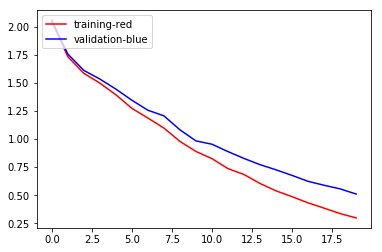

In [11]:
cnn = BasicCNN(10) 
#cnn.load_state_dict(torch.load('cnn.pt')['state_dict'])

optimizer = torch.optim.Adam(cnn.parameters(), weight_decay=0.0007)
trainCNN(cnn ,dataloaders,20,optimizer,3)

In [12]:
test_loader = DataLoader(test_loader_fused,batch_size=32)
ypred, ytrue = predictCNN(test_loader, cnn, criterion)
from sklearn.metrics import classification_report , accuracy_score
print(classification_report(ytrue, ypred))


Test loss: 2.5293605261378818
Test set accuracy is 31.83% 
              precision    recall  f1-score   support

           0       0.17      0.12      0.14        40
           1       0.44      0.57      0.50        40
           2       0.35      0.45      0.39        80
           3       0.32      0.33      0.32        80
           4       0.28      0.30      0.29        40
           5       0.12      0.10      0.11        40
           6       0.50      0.45      0.47        78
           7       0.06      0.03      0.03        40
           8       0.30      0.36      0.33       103
           9       0.18      0.12      0.14        34

    accuracy                           0.32       575
   macro avg       0.27      0.28      0.27       575
weighted avg       0.30      0.32      0.31       575



Παρατηρούμε από τα παραπάνω αποτελέσματα πως ναι μεν το accuracy είναι ανεβασμένο λίγο αλλά στο Classification Report είναι εμφανές πως πλέον προβλέπουμε όλες τις κλάσεις, ενώ με το μοντέλο της προπαρασκευαστικής, υπήρχαν κλάσεις οι οποίες δεν τις προέβλεπε καν. Πιθανότατα ο λόγος που δεν έχουμε ακόμα καλύτερο accuracy είναι ότι βάλαμε πολλά δεδομένα για training και είχαμε μια μορφή overfitting. 

In [13]:
#Saving a checkpoint
#torch.save(checkpoint, 'cnn.pt')
#Loading a checkpoint
#checkpoint = torch.load( 'cnn.pt')

'''
checkpoint = {'model': BasicCNN(10),
          'state_dict': cnn_model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'cnn.pt')
'''

"\ncheckpoint = {'model': BasicCNN(10),\n          'state_dict': cnn_model.state_dict(),\n          'optimizer' : optimizer.state_dict()}\n\ntorch.save(checkpoint, 'cnn.pt')\n"

### STEP 8 ~ Εκτίμηση συναισθήματος - συμπεριφοράς με παλινδρόμηση

Θα γίνει χρήση της μετρικής spearman correlation. Για κάθε συναίσθημα δείχνουμε και το spearman correlation όμως στο τέλος τα κάνουμε όλα concatenate και το ξανα υπολογίζουμε μαζί με όλες τις διαστάσεις.

Πρώτα θα φορτώσουμε το LSTM 

In [14]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, dropout, bidirectional=False, pad_packed=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.input_size = input_dim
        self.num_layers= num_layers
        self.output_size = output_dim
        self.dropout = dropout
        self.pad_packed = pad_packed
        self.lstm = nn.LSTM(self.input_size, rnn_size, self.num_layers, dropout=self.dropout, 
                            batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(self.feature_size, self.output_size)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        # if stacked is true use pack_padded_sequence and pad_packed_sequence
        if self.pad_packed:
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True)
            lstm_outs, hidden = self.lstm(packed)
            lstm_outs, lengths = nn.utils.rnn.pad_packed_sequence(lstm_outs, batch_first=True) 
        else:
            lstm_outs, hidden = self.lstm(x)
        last_out = self.last_timestep(lstm_outs, lengths, self.bidirectional)
        output = self.fc(last_out)
        return output

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)
    
    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

Να αναφέρουμε ότι παρακάτω οι συναρτήσεις train όταν τρέχουν για regression δεν εκτυπώνουν το accuracy αλλά μόνο το loss , γιατί στο classification υπολογίζαμε και το accuracy αλλά τώρα όχι.

In [15]:
def trainLSTM(model,dataloaders,num_epochs,optimizer,patience):
    Flag=False
    # for loss
    val_loss = []
    train_loss = []
    phase1 = dataloaders.keys()
    criterion =  nn.MSELoss()
    train_loader = dataloaders['train']
    if(torch.cuda.is_available()):
        device = 0
        model.to(device)
    else:
        device = 'cpu'
        model.to(device)
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        counter = epoch # keeping this variable for plot function after for loop
        if Flag == True:
            break
        print('Epoch:',epoch + 1)
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for  batch_idx, data in enumerate(dataloaders[phase]):
                optimizer.zero_grad()
                output = model(data[0].to(device), data[2].to(device)).to(device)
                loss = criterion(output, data[1].double().to(device))
                epoch_metrics["loss"].append(loss.item())
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
                % (
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
            
            epoch_loss = np.mean(epoch_metrics["loss"])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else: 
                val_loss.append(epoch_loss)
            if(phase == 'val' and patience !=None):
                earlystop(epoch_loss,model)
                if(earlystop.early_stop):
                    print("Early stopping")
                    model.load_state_dict(torch.load('./checkpoint.pt'))
                    #break
                    Flag = True

    if counter == num_epochs -1:
        epochs_axis = np.arange(num_epochs)
    else:
        epochs_axis = np.arange(counter)
    plt.plot(epochs_axis, train_loss,color='red')
    plt.plot(epochs_axis, val_loss,color='blue')
    plt.legend(['training-red', 'validation-blue'], loc='upper left')
    plt.show()

Παρακάτω τροποποιούμε το Spectrogram Dataset ώστε να διαβάζει ανάλογα με το target που θα του δώσουμε τα νέα μας δεδομένα ανάλογα με το αντίστοιχο target π.χ. valence , energy , danceability.

Ο λόγος που φτιάξαμε το dictionary αυτό είναι ώστε να περνάμε το label που θέλουμε και να πέρνουμε την αντίστοιχη στήλη στο αρχείο αυτό.

Επίσης, κάναμε και κάποιες αλλαγές στο get files για να διαβάζεται στη σωστή μορφή το αρχείο και αφαιρέσαμε το class mapping εφόσον πλέον δεν έχουμε κλάσεις.

In [16]:
class MultiDatasetLstm(Dataset):
    def __init__(self, path, target ,train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        label_dict = {'valence': 1, 'energy': 2, 'danceability': 3}
        self.label_idx = label_dict[target]
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index,self.label_idx)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
            
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float32')
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt, label_idx ):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            l = l[0].split(',')
            _id = l[0]
            label = l[label_idx]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):

        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l
        
    
    def __len__(self):
        return len(self.labels)

Διαβάζουμε τα beat sync multitask δεδομένα.

In [17]:
multispec_valence = MultiDatasetLstm('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/','valence',train=True)

In [18]:
train_loader, val_loader = torch_train_val_split(multispec_valence, 32 ,32, val_size=.2, shuffle=True)

In [19]:
for i,item in enumerate(val_loader):
    print(item[1].double())
    if i == 0:
        break

tensor([0.6440, 0.6170, 0.6090, 0.6450, 0.7620, 0.3670, 0.7190, 0.7630, 0.7940,
        0.8640, 0.5950, 0.2040, 0.0615, 0.9680, 0.6810, 0.5380, 0.7480, 0.6090,
        0.3730, 0.4320, 0.3210, 0.3590, 0.5330, 0.4340, 0.9000, 0.9150, 0.3770,
        0.1930, 0.4870, 0.5810, 0.4150, 0.7790], dtype=torch.float64)


Παρακάτω αλλάζουμε τον optimizer σε mean squared error loss ώστε να πάρει τη μορφή regression το πρόβλημα μας. Τα άλλα παραμένουν ίδια.

In [20]:
lstm_model_regression = BasicLSTM(140,20,1,2,0.1,True,False).double()
optimizer_mse = torch.optim.Adam(lstm_model_regression.parameters(), weight_decay=0.0007)

Epoch: 1
[Epoch 1/50] [Batch 5/29] [Loss: 0.183003 (0.327568)]

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 1/50] [Batch 5/7] [Loss: 0.052865 (0.126705)]

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 1/50] [Batch 6/7] [Loss: 0.046806 (0.124485)]Validation loss decreased (inf --> 0.124485).  Saving model ...
Epoch: 2
[Epoch 2/50] [Batch 6/7] [Loss: 0.047965 (0.067554)]Validation loss decreased (0.124485 --> 0.067554).  Saving model ...
Epoch: 3
[Epoch 3/50] [Batch 6/7] [Loss: 0.056535 (0.067024)]Validation loss decreased (0.067554 --> 0.067024).  Saving model ...
Epoch: 4
[Epoch 4/50] [Batch 6/7] [Loss: 0.068445 (0.065904)]Validation loss decreased (0.067024 --> 0.065904).  Saving model ...
Epoch: 5
[Epoch 5/50] [Batch 6/7] [Loss: 0.060801 (0.066381)]EarlyStopping counter: 1 out of 4
Epoch: 6
[Epoch 6/50] [Batch 6/7] [Loss: 0.063442 (0.067590)]EarlyStopping counter: 2 out of 4
Epoch: 7
[Epoch 7/50] [Batch 6/7] [Loss: 0.049642 (0.068507)]EarlyStopping counter: 3 out of 4
Epoch: 8
[Epoch 8/50] [Batch 6/7] [Loss: 0.076187 (0.068183)]EarlyStopping counter: 4 out of 4
Early stopping


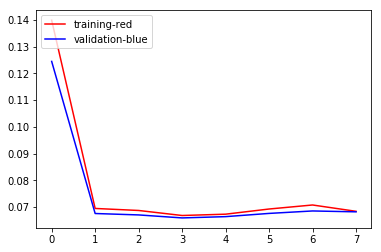

In [21]:
dataloaders = {'train':train_loader,'val':val_loader}
trainLSTM(lstm_model_regression,dataloaders ,50,optimizer_mse,4)


In [22]:
def LSTM_REG(test_loader, model, criterion):
    predictions, y_test, test_loss = [], [], []
    #model.load_state_dict(torch.load("LSTMmodel_params.pt"))
    # set eval mode in order to stop dropout during inference
    model.eval()
    if(torch.cuda.is_available()):
        device = 0
    else:
        device = 'cpu'
    model.to(device)
    for i_batch, data_batched in enumerate(test_loader, 0):
        data_batched[0], data_batched[2] = data_batched[0].to(device), data_batched[2].to(device)
        y_pred = model(data_batched[0], data_batched[2]).to(device)
        preds = y_pred.data.cpu().numpy()
        predictions += list(preds)
        # get sorted version of y_test
        data_batched[1] = data_batched[1].to(device)
        y_test += list(data_batched[1].data.cpu().numpy())
        loss = criterion(y_pred, data_batched[1].double()) 
        test_loss.append(loss.item()) 
    total_loss = np.mean(test_loss)
    print('Test loss: {}'.format(total_loss))
    return predictions, y_test

In [23]:
from scipy.stats import spearmanr
test_loader = DataLoader(multispec_valence, batch_size=32)
criterion_regr = nn.MSELoss()
predictions, labels = LSTM_REG(test_loader, lstm_model_regression, criterion_regr)
spearmanr(labels, predictions)                                  

Test loss: 0.06444811924869881


SpearmanrResult(correlation=0.014021707635082807, pvalue=0.6389449665042126)

Παραπάνω βλέπουμε το test loss και το spearman correlation 

Πριν τρέξαμε για το valence , τώρα θα δοκιμάσουμε το energy.

Epoch: 1
[Epoch 1/50] [Batch 6/7] [Loss: 0.043166 (0.134939)]Validation loss decreased (inf --> 0.134939).  Saving model ...
Epoch: 2
[Epoch 2/50] [Batch 6/7] [Loss: 0.066743 (0.069228)]Validation loss decreased (0.134939 --> 0.069228).  Saving model ...
Epoch: 3
[Epoch 3/50] [Batch 6/7] [Loss: 0.093335 (0.068303)]Validation loss decreased (0.069228 --> 0.068303).  Saving model ...
Epoch: 4
[Epoch 4/50] [Batch 6/7] [Loss: 0.069816 (0.066797)]Validation loss decreased (0.068303 --> 0.066797).  Saving model ...
Epoch: 5
[Epoch 5/50] [Batch 6/7] [Loss: 0.098325 (0.066701)]Validation loss decreased (0.066797 --> 0.066701).  Saving model ...
Epoch: 6
[Epoch 6/50] [Batch 6/7] [Loss: 0.054302 (0.066866)]EarlyStopping counter: 1 out of 4
Epoch: 7
[Epoch 7/50] [Batch 6/7] [Loss: 0.046752 (0.065869)]Validation loss decreased (0.066701 --> 0.065869).  Saving model ...
Epoch: 8
[Epoch 8/50] [Batch 6/7] [Loss: 0.063430 (0.067121)]EarlyStopping counter: 1 out of 4
Epoch: 9
[Epoch 9/50] [Batch 6/7] [

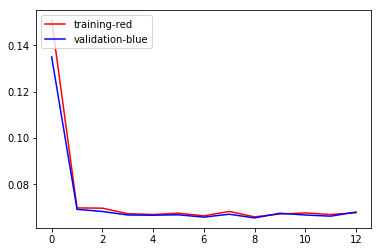

In [24]:
multispec_energy = MultiDatasetLstm('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/','energy',train=True)
train_loader, val_loader = torch_train_val_split(multispec_energy, 32 ,32, val_size=.2, shuffle=True)
dataloaders = {'train':train_loader,'val':val_loader}


lstm_model_regression2 = BasicLSTM(140,20,1,2,0.1,True,False).double()
optimizer_mse2 = torch.optim.Adam(lstm_model_regression2.parameters(), weight_decay=0.0007)

trainLSTM(lstm_model_regression2,dataloaders ,50,optimizer_mse2,4)


In [25]:
test_loader = DataLoader(multispec_energy, batch_size=32)
#criterion_regr = nn.MSELoss()
predictions2, labels2 = LSTM_REG(test_loader, lstm_model_regression2, criterion_regr)
spearmanr(labels2, predictions2) 

Test loss: 0.06699514360317434


SpearmanrResult(correlation=-0.2726611173108237, pvalue=1.40826160148605e-20)

Tώρα θα προβλέψουμε το Danceability

Epoch: 1
[Epoch 1/50] [Batch 6/7] [Loss: 0.452656 (0.405814)]Validation loss decreased (inf --> 0.405814).  Saving model ...
Epoch: 2
[Epoch 2/50] [Batch 6/7] [Loss: 0.484280 (0.405409)]Validation loss decreased (0.405814 --> 0.405409).  Saving model ...
Epoch: 3
[Epoch 3/50] [Batch 6/7] [Loss: 0.448772 (0.397324)]Validation loss decreased (0.405409 --> 0.397324).  Saving model ...
Epoch: 4
[Epoch 4/50] [Batch 6/7] [Loss: 0.477198 (0.396369)]Validation loss decreased (0.397324 --> 0.396369).  Saving model ...
Epoch: 5
[Epoch 5/50] [Batch 6/7] [Loss: 0.437593 (0.397924)]EarlyStopping counter: 1 out of 4
Epoch: 6
[Epoch 6/50] [Batch 6/7] [Loss: 0.429348 (0.394275)]Validation loss decreased (0.396369 --> 0.394275).  Saving model ...
Epoch: 7
[Epoch 7/50] [Batch 6/7] [Loss: 0.378329 (0.395405)]EarlyStopping counter: 1 out of 4
Epoch: 8
[Epoch 8/50] [Batch 6/7] [Loss: 0.387830 (0.401868)]EarlyStopping counter: 2 out of 4
Epoch: 9
[Epoch 9/50] [Batch 6/7] [Loss: 0.464114 (0.402271)]EarlyStop

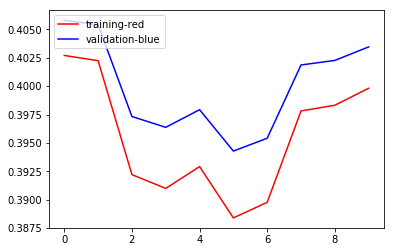

Test loss: 0.39522520219228974


SpearmanrResult(correlation=0.0613782214684249, pvalue=0.0398222460391125)

In [26]:
multispec_dance = MultiDatasetLstm('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/','danceability',train=True)
train_loader, val_loader = torch_train_val_split(multispec_dance, 32 ,32, val_size=.2, shuffle=True)
dataloaders = {'train':train_loader,'val':val_loader}


lstm_model_regression3 = BasicLSTM(140,20,1,2,0.1,True,False).double()
optimizer_mse3 = torch.optim.Adam(lstm_model_regression3.parameters(), weight_decay=0.0007)

trainLSTM(lstm_model_regression3,dataloaders ,50,optimizer_mse2,4)

test_loader = DataLoader(multispec_dance, batch_size=32)
#criterion_regr = nn.MSELoss()
predictions3, labels3 = LSTM_REG(test_loader, lstm_model_regression3, criterion_regr)
spearmanr(labels3, predictions3) 


__Συνολικό Spearman result__

In [27]:
ypred = np.concatenate((predictions,predictions2,predictions3),axis=0)
ytrue = np.concatenate((labels,labels2,labels3),axis=0)
spearmanr(ytrue, ypred) 

SpearmanrResult(correlation=0.12500227842273337, pvalue=3.3841368435611497e-13)

__Παρακάτω θα εκπαιδεύσουμε το CNN για να προβλέψει τις 3 συνιστώστες που θέλουμε.__

Ίδια κλάση με αυτή για το Multitask LSTM αλλά πλέον ξανά κάνουμε expand τις διαστάσεις στο getitem καθώς θέλουμε 4 διαστάσεις για το CNN.

In [28]:
class MultiDatasetCnn(Dataset): ## expanding dimensions...
    def __init__(self, path, target ,train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        label_dict = {'valence': 1, 'energy': 2, 'danceability': 3}
        self.label_idx = label_dict[target]
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index,self.label_idx)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
            
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float32')
        #print([f.shape for f in self.feats] )

    def get_files_labels(self, txt, label_idx ):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            l = l[0].split(',')
            _id = l[0]
            label = l[label_idx]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return np.expand_dims(self.zero_pad_and_stack(self.feats[item]), 0), self.labels[item], l
        
    
    def __len__(self):
        return len(self.labels)

Epoch: 1
[Epoch 1/20] [Batch 6/7] [Loss: 0.096011 (0.130678), Acc: 0.00% (0.00%)]Validation loss decreased (inf --> 0.130678).  Saving model ...
val Accuracy: 0.0
Epoch: 2
[Epoch 2/20] [Batch 6/7] [Loss: 0.077098 (0.081909), Acc: 0.00% (0.00%)]Validation loss decreased (0.130678 --> 0.081909).  Saving model ...
val Accuracy: 0.0
Epoch: 3
[Epoch 3/20] [Batch 6/7] [Loss: 0.070514 (0.064327), Acc: 0.00% (0.00%)]Validation loss decreased (0.081909 --> 0.064327).  Saving model ...
val Accuracy: 0.0
Epoch: 4
[Epoch 4/20] [Batch 6/7] [Loss: 0.080209 (0.056194), Acc: 0.00% (0.00%)]Validation loss decreased (0.064327 --> 0.056194).  Saving model ...
val Accuracy: 0.0
Epoch: 5
[Epoch 5/20] [Batch 6/7] [Loss: 0.114956 (0.049651), Acc: 0.00% (0.00%)]Validation loss decreased (0.056194 --> 0.049651).  Saving model ...
val Accuracy: 0.0
Epoch: 6
[Epoch 6/20] [Batch 6/7] [Loss: 0.062903 (0.046324), Acc: 0.00% (0.00%)]Validation loss decreased (0.049651 --> 0.046324).  Saving model ...
val Accuracy: 0

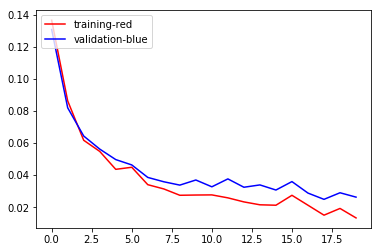

In [29]:
cnn_spec_valence = MultiDatasetCnn('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/','valence',train=True)
train_loader, val_loader = torch_train_val_split(cnn_spec_valence, 32 ,32, val_size=.2, shuffle=True)
dataloaders = {'train':train_loader,'val':val_loader}
model_cnn_multi = BasicCNN(1)
optimizerCNN = torch.optim.Adam(model_cnn_multi.parameters(), weight_decay=0.001)
trainCNN(model_cnn_multi ,dataloaders,20,optimizerCNN,4,True) # true for mseloss criterion

In [30]:
test_loader = DataLoader(cnn_spec_valence, batch_size=32)
criterion_regr = nn.MSELoss()
predictions_cnn, labels_cnn = CNN_REG(test_loader, model_cnn_multi, criterion_regr)
spearmanr(labels_cnn, predictions_cnn) 

Test loss: 0.04630210085047616


SpearmanrResult(correlation=0.8333189995161571, pvalue=1.3358874111631322e-290)

Πάμε να δούμε τώρα το energy

Epoch: 1
[Epoch 1/20] [Batch 6/7] [Loss: 0.059555 (0.154212), Acc: 0.00% (0.00%)]Validation loss decreased (inf --> 0.154212).  Saving model ...
val Accuracy: 0.0
Epoch: 2
[Epoch 2/20] [Batch 6/7] [Loss: 0.062978 (0.066688), Acc: 0.00% (0.00%)]Validation loss decreased (0.154212 --> 0.066688).  Saving model ...
val Accuracy: 0.0
Epoch: 3
[Epoch 3/20] [Batch 6/7] [Loss: 0.088857 (0.061723), Acc: 0.00% (0.00%)]Validation loss decreased (0.066688 --> 0.061723).  Saving model ...
val Accuracy: 0.0
Epoch: 4
[Epoch 4/20] [Batch 6/7] [Loss: 0.045917 (0.046200), Acc: 0.00% (0.00%)]Validation loss decreased (0.061723 --> 0.046200).  Saving model ...
val Accuracy: 0.0
Epoch: 5
[Epoch 5/20] [Batch 6/7] [Loss: 0.060032 (0.040911), Acc: 0.00% (0.00%)]Validation loss decreased (0.046200 --> 0.040911).  Saving model ...
val Accuracy: 0.0
Epoch: 6
[Epoch 6/20] [Batch 6/7] [Loss: 0.066417 (0.036357), Acc: 0.00% (0.00%)]Validation loss decreased (0.040911 --> 0.036357).  Saving model ...
val Accuracy: 0

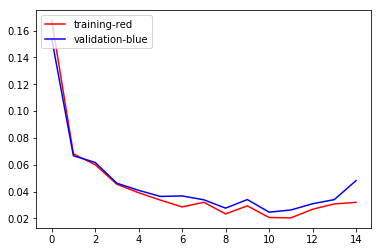

Test loss: 0.020431494909442134


SpearmanrResult(correlation=0.834369020866673, pvalue=5.3400097128561114e-292)

In [31]:
cnn_spec_energy = MultiDatasetCnn('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/','energy',train=True)
train_loader, val_loader = torch_train_val_split(cnn_spec_energy, 32 ,32, val_size=.2, shuffle=True)
dataloaders = {'train':train_loader,'val':val_loader}
model_cnn_multi_2 = BasicCNN(1)
optimizerCNN2 = torch.optim.Adam(model_cnn_multi_2.parameters(), weight_decay=0.001)
trainCNN(model_cnn_multi_2,dataloaders,20,optimizerCNN2,4,True) # true for mseloss criterion

test_loader = DataLoader(cnn_spec_energy, batch_size=32)
predictions_cnn2, labels_cnn2 = CNN_REG(test_loader, model_cnn_multi_2, criterion_regr)
spearmanr(labels_cnn2, predictions_cnn2) 

Tώρα θα δούμε τα αποτελέσματα για το danceability

Epoch: 1
[Epoch 1/20] [Batch 6/7] [Loss: 0.078989 (0.114582), Acc: 0.00% (0.00%)]Validation loss decreased (inf --> 0.114582).  Saving model ...
val Accuracy: 0.0
Epoch: 2
[Epoch 2/20] [Batch 6/7] [Loss: 0.083715 (0.061306), Acc: 0.00% (0.00%)]Validation loss decreased (0.114582 --> 0.061306).  Saving model ...
val Accuracy: 0.0
Epoch: 3
[Epoch 3/20] [Batch 6/7] [Loss: 0.060703 (0.042332), Acc: 0.00% (0.00%)]Validation loss decreased (0.061306 --> 0.042332).  Saving model ...
val Accuracy: 0.0
Epoch: 4
[Epoch 4/20] [Batch 6/7] [Loss: 0.144091 (0.069596), Acc: 0.00% (0.00%)]EarlyStopping counter: 1 out of 4
val Accuracy: 0.0
Epoch: 5
[Epoch 5/20] [Batch 6/7] [Loss: 0.073812 (0.053498), Acc: 0.00% (0.00%)]EarlyStopping counter: 2 out of 4
val Accuracy: 0.0
Epoch: 6
[Epoch 6/20] [Batch 6/7] [Loss: 0.041547 (0.032378), Acc: 0.00% (0.00%)]Validation loss decreased (0.042332 --> 0.032378).  Saving model ...
val Accuracy: 0.0
Epoch: 7
[Epoch 7/20] [Batch 6/7] [Loss: 0.038485 (0.032754), Acc: 

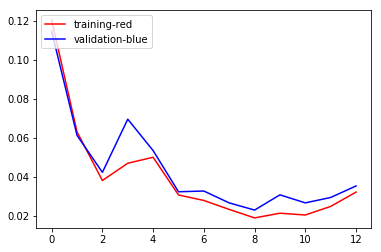

Test loss: 0.08514686270306508


SpearmanrResult(correlation=-0.01216706193240485, pvalue=0.6839257573179842)

In [32]:
cnn_spec_dance = MultiDatasetCnn('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/','danceability',train=True)
train_loader, val_loader = torch_train_val_split(cnn_spec_energy, 32 ,32, val_size=.2, shuffle=True)
dataloaders = {'train':train_loader,'val':val_loader}
model_cnn_multi_3 = BasicCNN(1)
optimizerCNN3 = torch.optim.Adam(model_cnn_multi_3.parameters(), weight_decay=0.001)
trainCNN(model_cnn_multi_3,dataloaders,20,optimizerCNN3,4,True) # true for mseloss criterion

test_loader = DataLoader(cnn_spec_dance, batch_size=32)
predictions_cnn3, labels_cnn3 = CNN_REG(test_loader, model_cnn_multi_3, criterion_regr)
spearmanr(labels_cnn3, predictions_cnn3) 

Παρακάτω βλέπουμε για το CNN REGRESSION το συνολικό spearman correlation

In [33]:
ypred = np.concatenate((predictions_cnn,predictions_cnn2,predictions_cnn3),axis=0)
ytrue = np.concatenate((labels_cnn,labels_cnn2,labels_cnn3),axis=0)
spearmanr(ytrue, ypred) 

SpearmanrResult(correlation=0.5558631321386905, pvalue=2.58465201984858e-272)

Παρατηρούμε ότι το cnn μας έδωσε καλύτερα αποτελέσματα όσον αφορά την εκτίμηση συναισθημάτων από ότι το lstm.